# Vector Quantized VAE (VQ-VAE)

by: ***Anthony Bao***

In the previous notebook (https://github.com/williamgilpin/cphy/blob/main/vignettes/basic_vae.ipynb) we introduced Variational Autoencoders (VAE) and the Evidence Lower Bound (ELBO). Now, there has been a tremendous body of work on improving VAEs with newer architecture, stabilized training, etc. But fundamentally, we want to depart from our Gaussian assumption on the latent variables, because such a simple assumption limits expressivity and can give us a loose or "broken" ELBO (Fixing a Broken ELBO: https://arxiv.org/pdf/1711.00464.pdf, Variational Inference with Normalizing Flows: https://arxiv.org/pdf/1505.05770.pdf). This notebook will provide a *minimalistic* but effective implementation of VQ-VAE, explaining all the components and the usefulness of this method./

***The Main Idea***: VQ-VAE learns a discretized latent space, which is intuitively better-suited for discrete data such as images. It does this by introducing a powerful PixelCNN prior for the latent space, which is far more expressive than the vanilla Gaussian assumption. Instead of being normally-distributed variables, the latent space now consists of single channel images of reduced dimension.

References:

1. *VQ-VAE*
    * Aaron van den Oord, Oriol Vinyals, and Koray Kavukcuoglu. Neural discrete representation learning. In NIPS, pages 6306–6315, 2017. https://arxiv.org/pdf/1711.00937.pdf
    * Original implementation (Tensorflow): https://github.com/google-deepmind/sonnet/blob/v1/sonnet/python/modules/nets/vqvae.py
2. *VQ-VAE-2*
    * Ali Razavi, Aaron van den Oord, and Oriol Vinyals. Generating diverse high-fidelity images with VQ-VAE-2. In NeurIPS, pages 14837–14847, 2019. https://papers.nips.cc/paper_files/paper/2019/file/5f8e2fa1718d1bbcadf1cd9c7a54fb8c-Paper.pdf
    * Results are pretty impressive. Was comparable to BigGAN back in 2019. But with the more recent successes of diffusion models, these are no longer in the running for the state-of-the-art (SOTA). However, the vector quantization of the latent space is a very general idea that is used in many components of the most popular generative models today, including Stable Diffusion and DALL-E.

Open-source implementations:
1. pythae: https://github.com/clementchadebec/benchmark_VAE
    * Great, optimized code covers many types of VAEs, with different samplers and distributed training scripts
    * **I recommend starting with this repo if you want to apply VAEs in your research**
2. vq-vae-2-pytorch: https://github.com/rosinality/vq-vae-2-pytorch
    * Best implementation of VQ-VAE-2 that I could find

Note: in constructing this notebook, the following community implementations were also useful: https://github.com/AntixK/PyTorch-VAE/tree/master and https://github.com/ritheshkumar95/pytorch-vqvae/tree/master and https://github.com/MishaLaskin/vqvae/tree/master (in particular, many parts of this notebook are adapted from the latter)

***Physical Applications***: TODO. For a good but outdated survey, check out Pankaj Mehta et al. "A high bias, low variance introduction to machine learning for physicists" https://arxiv.org/pdf/1803.08823.pdf in which they implement a primitive autoencoder and use on Ising model dataset

### More Reading

Blog Posts:
1. Berkeley ML substack: https://mlberkeley.substack.com/p/vq-vae
2. Neural compression: https://pub.towardsai.net/stable-diffusion-based-image-compresssion-6f1f0a399202

VQ-VAE and its variants (especially variants of VQ-VAE-2) are very popular NN-based compression models that are used as components for many larger models. For instance, Stable Diffusion (built on Latent Diffusion Models) uses vector quantization based on the VQ-VAE framework to first learn a lower-dimensional representation that is perceptually equivalent to the data space. At a high level, the perceptual compression stage (with VQ-VAE) removes high-frequency details but still learns the underlying semantic content. Then, the generative model (diffusion, which is essentially a bunch of noising/denoising steps, in the latent space) learns the semantic and conceptual composition of the data. For more details, check out https://arxiv.org/pdf/2112.10752.pdf

"This paradigm of training a VQ-VAE and then learning an updated prior, is the exact formula that OpenAI has successfully used in several of their groundbreaking recent releases. OpenAI’s jukebox, a model that is able to generate original songs from raw audio, trains a VQ-VAE on audio and then uses a transformer trained on the latents to generate new audio samples. Their recently released text to image model, DALL-E, involves a transformer that takes as input both the embeddings from text and the latent codes from a VQ-VAE trained on images. Of course, some of these works are using a few additional tricks that are outside the scope of this blog post, like hierarchical VQ-VAEs and different relaxations for making the VQ-VAE bottleneck differentiable." - Berkeley ML substack

## The Main Idea

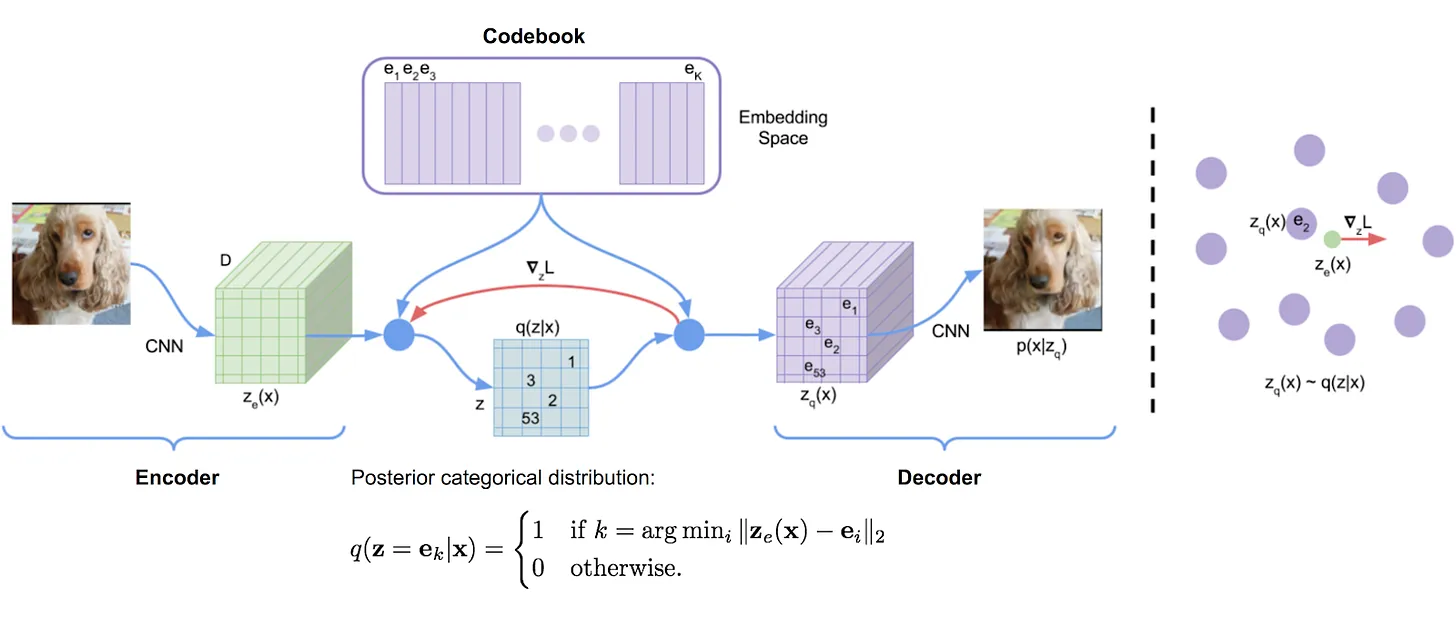

# Implementation

### Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import time
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid

In [ ]:
# set the device, default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Config and Utils

In [ ]:
# We keep this as global variable we will reference throughout this notebook
config = {
    'batch_size': 64,
    'n_channels': 1, # for MNIST
    'n_epochs': 10,
    'n_hiddens': 128,
    'n_residual_hiddens': 32,
    'n_residual_layers': 2,
    'embedding_dim': 16,
    'n_embeddings': 128,
    'beta': 0.25,
    'learning_rate': 1e-3, # 3e-4
    'plot_epochs': 5, # plto every plot_epochs of training
    'dataset': 'MNIST',
    'data_dir': 'data/',
    'save_dir': 'results/',
    }

print(f'Model checkpoints and results will be saved in {config["save_dir"]}')
print(f'Data will be saved in {config["data_dir"]}')

if not os.path.exists(config["save_dir"]):
    os.makedirs(config["save_dir"])

if not os.path.exists(config["data_dir"]):
    os.makedirs(config["data_dir"])

Model checkpoints and results will be saved in results/
Data will be saved in data/


In [ ]:
def save_model_and_results(model, results):
    timestamp = int(time.time())
    save_path = os.path.join(config["save_dir"], f'vqvae_{config["dataset"]}_{timestamp}.pth')
    print(f"Saving checkpoint in: {save_path}")
    torch.save({
        'model': model.state_dict(),
        'results': results,
        'config': config
    }, save_path)

In [ ]:
# Plotting utils
def display_image_grid(x):
    x = make_grid(x.cpu().detach() + 0.5) # + 0.5 to undo normalization in loading (for mnist: transforms.Normalize((0.5), (0.5))]) )
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)).squeeze(), interpolation='nearest', cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

def display_image_grid_side_by_side(x, xhat, epoch=None):
    x = make_grid(x.cpu().detach() + 0.5) # + 0.5 to undo normalization in loading (for mnist: transforms.Normalize((0.5), (0.5))]) )
    x = x.numpy()
    xhat = make_grid(xhat.cpu().detach() + 0.5) # + 0.5 to undo normalization in loading (for mnist: transforms.Normalize((0.5), (0.5))]) )
    xhat = xhat.numpy()

    fig, axs = plt.subplots(ncols=2, figsize=(12, 12), squeeze=False)

    axs[0, 0].imshow(np.transpose(x, (1,2,0)).squeeze(), interpolation='nearest', cmap='gray')
    axs[0, 0].set_aspect('equal')
    axs[0, 0].axis('off')
    axs[0, 0].set_title("True")

    title_generated = "Generated" if epoch is None else f"Generated (Epoch {epoch})"
    axs[0, 1].imshow(np.transpose(xhat, (1,2,0)).squeeze(), interpolation='nearest', cmap='gray')
    axs[0, 1].set_aspect('equal')
    axs[0, 1].axis('off')
    axs[0, 1].set_title(title_generated)

    plt.subplots_adjust(wspace=0.05, hspace=0.1)

## Load Data

In [ ]:
# # Add your custom dataset class here.
# # We have imported the CIFAR10 and MNIST dataset classes from torchvision.datasets
# from torch.utils.data import Dataset
# class MyDataset(Dataset):
#     def __init__(self):
#         pass

#     def __len__(self):
#         pass

#     def __getitem__(self, idx):
#         pass

In [ ]:
# Make a class for our data... hopefull will help with scalability
class VQVAE_Data():
    def __init__(self, dataset, data_dir, batch_size):
        self.dataset = dataset
        self.data_dir = data_dir
        self.batch_size = batch_size
        # initial values, will be set by this class's methods
        self.train_data = None
        self.val_data = None
        # variances of the training data
        self.train_data_vars = None

    def _load_cifar10(self):
        save_dir = os.path.join(self.data_dir, "cifar10")
        # https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
        transforms_cifar10 = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train = datasets.CIFAR10(root=save_dir, train=True, download=True,
                                transform=transforms_cifar10)
        val = datasets.CIFAR10(root=save_dir, train=False, download=True,
                              transform=transforms_cifar10)
        return train, val

    def _load_mnist(self):
        save_dir = os.path.join(self.data_dir, "mnist")
        transforms_mnist = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5), (0.5))])
        train = datasets.MNIST(root=save_dir, train=True, download=True,
                              transform=transforms_mnist)
        val = datasets.MNIST(root=save_dir, train=False, download=True,
                              transform=transforms_mnist)
        return train, val

    def _dataloaders(self):
        train_loader = DataLoader(self.train_data,
                                  batch_size=self.batch_size,
                                  shuffle=True,
                                  drop_last=True,
                                  pin_memory=True)
        val_loader = DataLoader(self.val_data,
                                batch_size=self.batch_size,
                                shuffle=True,
                                drop_last=True,
                                pin_memory=True)
        return train_loader, val_loader

    def build_all(self):
        '''
        Loads and stores the data, builds the dataloader, stores variances of training data
        Returns train_loader and val_loader
        '''
        if self.dataset == 'CIFAR10':
            train_data, val_data = self._load_cifar10()
            train_data_vars = np.var(train_data.data / 255.0) # note: if this messes up, we need to reload the data or compute from dir

        elif self.dataset == 'MNIST':
            # note this comes as Torch tensor
            train_data, val_data = self._load_mnist()
            train_data_vars = np.var(train_data.data.numpy()) # note: if this messes up, we need to reload the data or compute from dir
        else:
            raise ValueError("Only CIFAR10 and MNIST datasets have been implemented so far.")

        self.train_data = train_data
        self.val_data = val_data
        self.train_data_vars = train_data_vars

        train_loader, val_loader = self._dataloaders()
        return train_loader, val_loader

    def get_train_variances(self):
        return self.train_data_vars

    def get_train_data(self):
        return self.train_data

    def get_val_data(self):
        return self.val_data

    def __call__(self):
        return self.build_all()

In [ ]:
# build dataloaders
vqvae_data = VQVAE_Data(config["dataset"], config["data_dir"], config["batch_size"])
train_loader, val_loader = vqvae_data.build_all()

In [ ]:
# We can use this to (optionally) normalize our reconstruction loss
train_data_vars = vqvae_data.get_train_variances()
print(train_data_vars)

6172.850482291342


## Residual Blocks

In [ ]:
class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

## Vector Quantizer

In [ ]:
class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, channel, height, width)

        quantization pipeline:

            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)

        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices

## Encoder and Decoder

In [ ]:
class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)
        )

    def forward(self, x):
        return self.conv_stack(x)


In [ ]:
class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, config["n_channels"], kernel_size=kernel, # set num_channels
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

## VQ-VAE
Putting it all together

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(config["n_channels"], h_dim, n_res_layers, res_h_dim) # set num_channels
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False): # generate

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(
            z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity

## Train

In [ ]:
model = VQVAE(config["n_hiddens"], config["n_residual_hiddens"], config["n_residual_layers"],
              config["n_embeddings"], config["embedding_dim"], config["beta"]).to(device)

In [ ]:
# # https://discuss.pytorch.org/t/torchsummary-return-error/67156 need to change ResidualStack for this to work
# from torchsummary import summary
# summary(model, (1,64,64))
model

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (pre_quantization_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  (vector_quantization): VectorQuantizer(
    (embedding): Embedding(128, 16)
  )
  (decoder): Decoder(
    (inverse_conv_stack): Sequential(
      (0): Con

In [ ]:
# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=True)

Average test loss: 0.69666


Epoch: 1 Avg train loss: 0.18863 Avg perplexity: 19.78131103515625


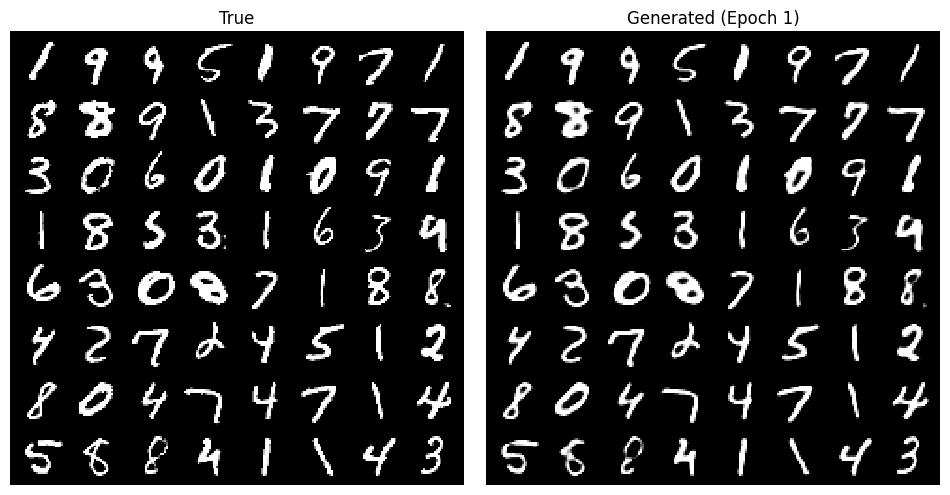

Average test loss: 0.02731
Epoch: 2 Avg train loss: 0.02239 Avg perplexity: 43.28575897216797
Average test loss: 0.01903
Epoch: 3 Avg train loss: 0.01817 Avg perplexity: 49.320701599121094
Average test loss: 0.01679
Epoch: 4 Avg train loss: 0.01641 Avg perplexity: 51.243038177490234
Average test loss: 0.01541


Epoch: 5 Avg train loss: 0.01513 Avg perplexity: 52.34713363647461


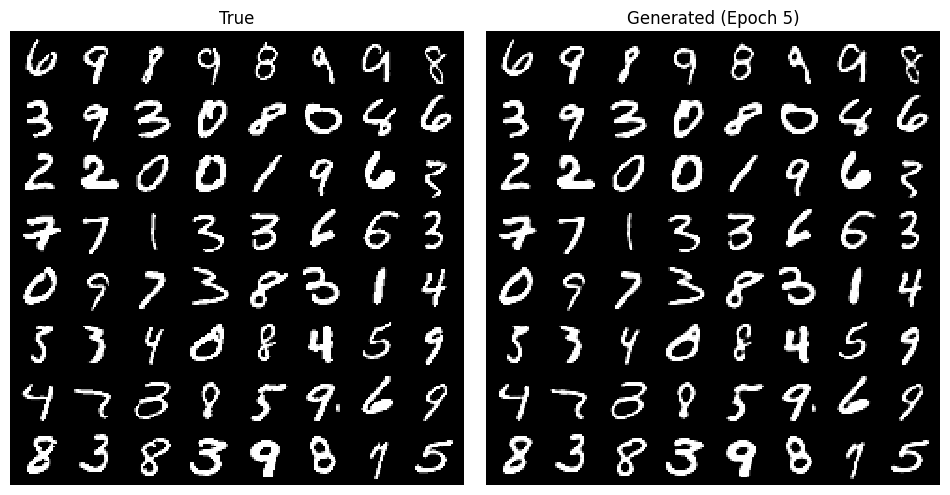

Average test loss: 0.01432
Epoch: 6 Avg train loss: 0.01419 Avg perplexity: 54.88123321533203
Average test loss: 0.01359
Epoch: 7 Avg train loss: 0.01365 Avg perplexity: 56.67380905151367
Average test loss: 0.01337
Epoch: 8 Avg train loss: 0.01323 Avg perplexity: 56.562801361083984
Average test loss: 0.01302
Epoch: 9 Avg train loss: 0.01291 Avg perplexity: 56.78515625
Average test loss: 0.01266


Epoch: 10 Avg train loss: 0.01264 Avg perplexity: 57.12921905517578


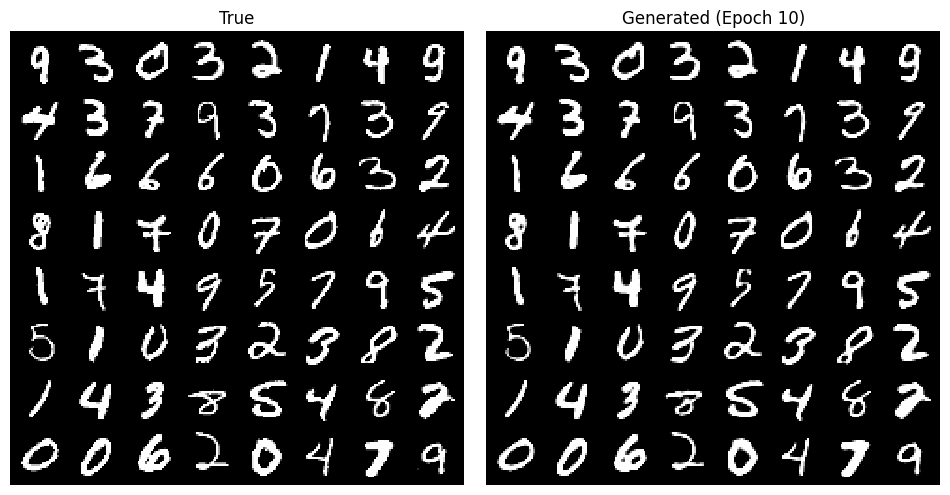

Average test loss: 0.01259
Saving checkpoint in: results/vqvae_MNIST_1697923284.pth
CPU times: user 3min 34s, sys: 2.43 s, total: 3min 36s
Wall time: 3min 57s


In [ ]:
%%time
# Initialize dict to store results
results = {
    'n_updates': 0,
    'train_recon_errors': [], # start of train results
    'train_perplexities': [],
    'train_losses': [],
    'avg_train_loss_epochs': [],
    # 'test_recon_errors': [], # start of test results
    # 'test_perplexities': [],
    'test_losses': [],
    'avg_test_loss_epochs': [],
}

iters_train = len(train_loader)
iters_test = len(val_loader)

# TODO: generate_images functionality, save avg epoch and per iterations results, implement testing loop

for epoch in range(config["n_epochs"] + 1):
    # Training
    if epoch > 0:  # test untrained net first
        # Set model to training mode
        model.train()
        train_loss = 0.
        for i, (x, _) in enumerate(train_loader): # iters_train
            x = x.to(device)
            # ===================forward=====================
            embedding_loss, x_hat, perplexity = model(x)
            recon_loss = torch.mean((x_hat - x)**2) #/ train_data_vars # NOTE: this is pretty interesting, not standard afaik
            loss = recon_loss + embedding_loss
            train_loss += loss #.item()

            # ===================backward====================
            # zero out the previous gradients to prevent accumulation
            optimizer.zero_grad()
            # backpropagate
            loss.backward()
            optimizer.step()
            # scheduler.step(epoch + i / iters_train)

            results["train_recon_errors"].append(recon_loss.cpu().detach().numpy())
            results["train_perplexities"].append(perplexity.cpu().detach().numpy())
            results["train_losses"].append(loss.cpu().detach().numpy())

        results["n_updates"] += iters_train
        avg_train_loss = train_loss / iters_train # len(train_loader.dataset)
        avg_perplexity = np.mean(results["train_perplexities"][-iters_train:])
        results["avg_train_loss_epochs"].append(avg_train_loss)
        print(f'Epoch: {epoch} Avg train loss: {avg_train_loss:.5f} Avg perplexity: {avg_perplexity}')

        # display images (include plot after first training epoch, epoch 1)
        if epoch == 1 or epoch % config["plot_epochs"] == 0:
            display_image_grid_side_by_side(x, x_hat, epoch=epoch)
            plt.show()

    # Testing (Validation)
    with torch.no_grad():
        model.eval()
        test_loss = 0.
        # image, label
        for x_test, y_test in val_loader:
            x_test = x_test.to(device)
            # ===================forward=====================
            embedding_loss, x_hat_test, perplexity = model(x_test)
            recon_loss = torch.mean((x_hat_test - x_test)**2) #/ train_data_vars # NOTE: this is pretty interesting, not standard afaik
            loss = recon_loss + embedding_loss
            test_loss += loss #.item()

            # results["test_recon_errors"].append(recon_loss.cpu().detach().numpy())
            # results["test_perplexities"].append(perplexity.cpu().detach().numpy())
            results["test_losses"].append(loss.cpu().detach().numpy())

    avg_test_loss = test_loss / iters_test # len(val_loader.dataset)
    results["avg_test_loss_epochs"].append(avg_test_loss)
    print(f'Average test loss: {avg_test_loss:.5f}')

# save model and results
save_model_and_results(model, results)

## Visualizations

### Utilities for model loading, visualization,

In [ ]:
def load_model(checkpoint_path):
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else: # CPU
        checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

    results = checkpoint["results"]
    config = checkpoint["config"]

    model = VQVAE(config['n_hiddens'], config['n_residual_hiddens'],
                  config['n_residual_layers'], config['n_embeddings'],
                  config['embedding_dim'], config['beta']).to(device)

    model.load_state_dict(checkpoint['model'])

    return model, config, results


from scipy.signal import savgol_filter

def plot_metrics(results):
    recon_errors = savgol_filter(results["train_recon_errors"], 19, 5)
    perplexities = savgol_filter(results["train_perplexities"], 19, 5)
    loss_vals = savgol_filter(results["train_losses"], 19, 5)


    f = plt.figure(figsize=(16,4))
    ax = f.add_subplot(1,3,2)
    ax.plot(recon_errors)
    ax.set_yscale('log')
    ax.set_title('Reconstruction Error')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,3)
    ax.plot(perplexities)
    ax.set_title('Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,1)
    ax.plot(loss_vals)
    ax.set_yscale('log')
    ax.set_title('Overall Loss')
    ax.set_xlabel('iteration')

def reconstruct(data_loader, model):
    (x, _) = next(iter(data_loader))
    x = x.to(device)
    vq_encoder_output = model.pre_quantization_conv(model.encoder(x))
    _, z_q, _, _,e_indices = model.vector_quantization(vq_encoder_output)

    x_recon = model.decoder(z_q)
    return x,x_recon, z_q, e_indices

### Load model from checkpoint

In [ ]:
# it's good practice to save your models, so we do that and load from checkpoint
checkpoint_path = 'results/vqvae_MNIST_1697923284.pth'
model, config, results = load_model(checkpoint_path)

### Smoothed Loss and Perplexity Values

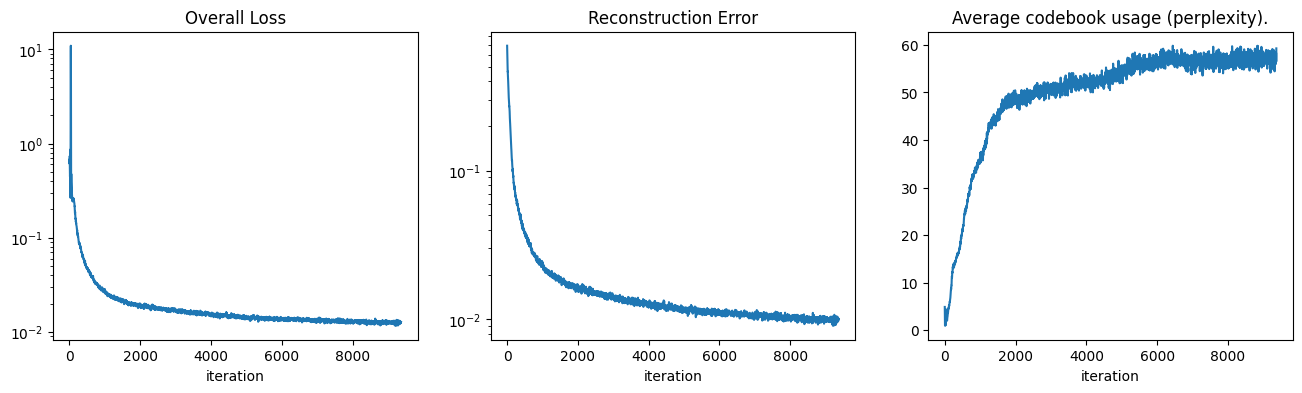

In [ ]:
plot_metrics(results)

### Visualize Generation

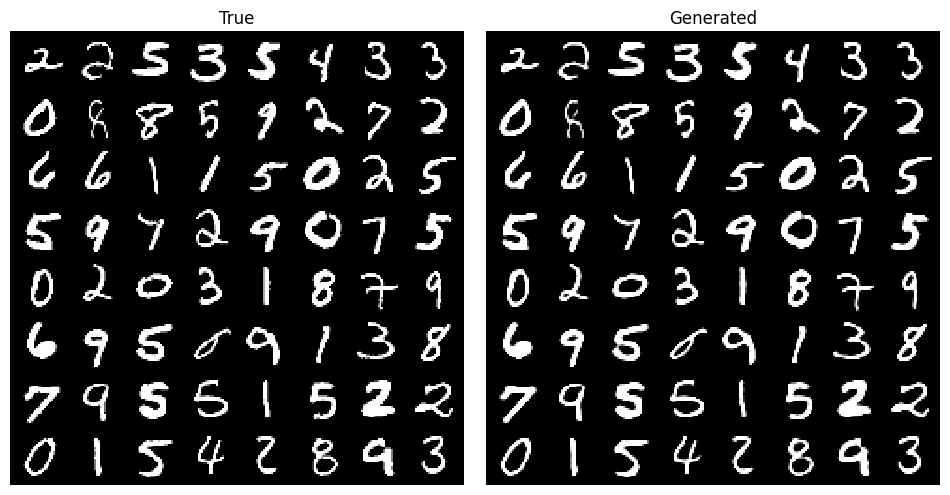

In [ ]:
x_val, x_val_recon, z_q, e_indices = reconstruct(val_loader, model)
display_image_grid_side_by_side(x_val, x_val_recon, epoch=None) # epoch=config["n_epochs"]

### Visualize Latents

In [ ]:
z_q.shape

torch.Size([64, 16, 7, 7])

In [ ]:
e_indices.shape

torch.Size([3136, 1])

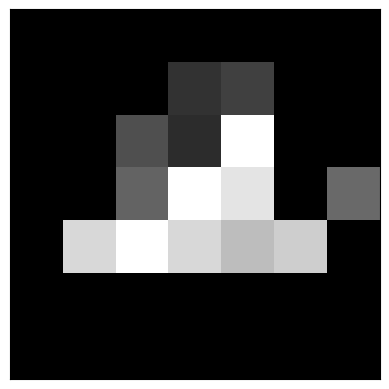

In [ ]:
display_image_grid(z_q[0,15:16,:,:])

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact(idx=(0,config["embedding_dim"],1))
def display_latents(idx=0):
    plt.figure()
    latents = z_q[0,idx:idx+1,:,:].detach().cpu().numpy()
    latents = np.transpose(latents, (1,2,0))
    print(latents.shape)
    plt.imshow(latents)
    plt.show()

# display_image_grid(z_q[:,8:9,:,:])

interactive(children=(IntSlider(value=0, description='idx', max=16), Output()), _dom_classes=('widget-interact…

# Sampling from latent space $z$

Sampling from VQ VAEs is more subtle than normal sampling schemes. To elucidate this point we'll present three sampling schemes:

1. Uniform sampling
2. Categorical sampling from a histogram
3. Sampling with an autoregressive PixelCNN

Sampling scheme (1) produces scrambled results, because only a small percentage of all possible representations are actually utilized. If you sample uniformly, you will most likely get results outside of the data distribution, which is why they appear random.

Sampling scheme (2) collects a histogram of representations and samples from the histogram. This works but is also incorrect because it limits us to only representations seen during construction of the histogram. Note that if $N_{\text{histogram}} \rightarrow \infty $ then this scheme will work, but since we can't actually do this, we want a better way to approximate the disribution of our representation space.

Scheme (3) is more complex but provides a principled way of sampling from the latent space. We train a Gated PixelCNN to approximate the distribution of the latent space.



## Uniform sampling of latent space



4096
128
torch.Size([4096, 128])
torch.Size([128, 16])
torch.Size([4096, 1])


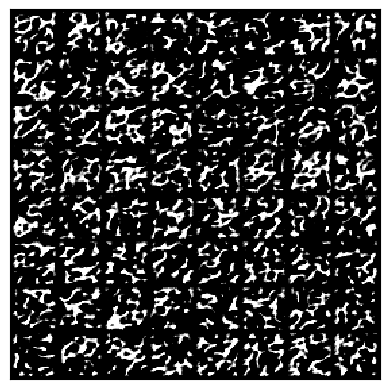

In [ ]:
def generate_samples(e_indices, shape=(8,8)):
    print(e_indices.shape[0])
    print(config['n_embeddings'])
    min_encodings = torch.zeros(e_indices.shape[0], config['n_embeddings']).to(device)
    min_encodings.scatter_(1, e_indices, 1)
    e_weights = model.vector_quantization.embedding.weight
    print(min_encodings.shape)
    print(e_weights.shape)
    z_q = torch.matmul(min_encodings, e_weights).view((config["batch_size"],shape[0],shape[1], config["embedding_dim"]))
    z_q = z_q.permute(0, 3, 1, 2).contiguous()

    x_recon = model.decoder(z_q)
    return x_recon, z_q,e_indices


def uniform_samples(model):

    rand = np.random.randint(config['n_embeddings'], size=(4096, 1))
    min_encoding_indices = torch.tensor(rand).long().to(device)
    x_recon, z_q, e_indices = generate_samples(min_encoding_indices, shape=(8,8)) # TODO

    print(min_encoding_indices.shape)
    return x_recon, z_q,e_indices

x_val_recon,z_q,e_indices = uniform_samples(model)

display_image_grid(x_val_recon)



## Categorial Distribution Sampling

Total representations used: 3200
4096
128
torch.Size([4096, 128])
torch.Size([128, 16])


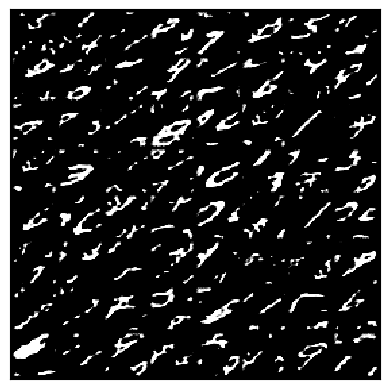

In [ ]:
N = 100

def encode_observations():
    all_e_indices = []
    for i in range(N):
        _,_,_,e_indices = reconstruct(val_loader,model)
        all_e_indices.append(e_indices)

    return torch.cat(all_e_indices)

e_indices = encode_observations()

def count_representations():
    d = {}
    for i in range(32*N):
        k = e_indices[64*i:64*i+64].squeeze().cpu().detach().numpy()
        k = [str(j)+'-' for j in k]
        k = ''.join(k)

        if k not in d:
            d[k] = 1
        else:
            d[k]+=1

    return d

hist = count_representations()
if '' in hist: del hist['']

print('Total representations used:',len(hist.keys()))
def sample_histogram(hist):
    keys, vals = np.array(list(hist.keys())),np.array(list(hist.values()))
    probs = np.array(vals)/sum(vals)
    samples = np.random.choice(keys, config['batch_size'],p=probs,replace=True)

    samples = np.array([np.array([int(y) for y in x.split('-')[:-1]]) for x in samples])

    return samples

samples = sample_histogram(hist)

def histogram_samples(model):
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices, shape=(8,8))

    return x_recon, z_q,e_indices

x_hist,_,_ = histogram_samples(model)

display_image_grid(x_hist)


## The most common representation

(4096, 1)
4096
128
torch.Size([4096, 128])
torch.Size([128, 16])


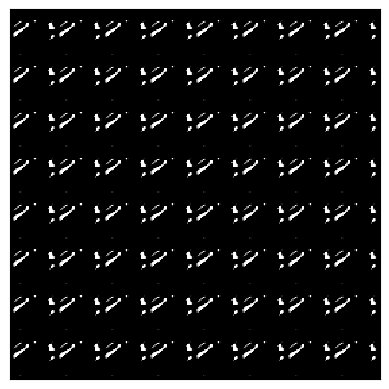

In [ ]:
most_common_sample_index = np.argmax(list(hist.values()))
most_common_z = np.array([int(y) for y in list(hist.keys())[most_common_sample_index].split('-')[:-1]])


def most_common_samples(model):

    samples = np.array(list(most_common_z)*64).reshape(-1,1)
    print(samples.shape)
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)

    return x_recon, z_q,e_indices


x_val_recon,z_q,e_indices = most_common_samples(model)

display_image_grid(x_val_recon)


# Reconstruct from PixelCNN

TODO: Not yet implemented! Even though, arguable, this is the most important part :D

In [ ]:
# import os
# data_folder_path = os.getcwd()
# data_file_path = data_folder_path + '/data/latent_samples.npy'

# samples = np.load(data_file_path,allow_pickle=True)

In [ ]:
# def reconstruct_from_pixelcnn(model,samples):
#     '''
#     TODO: not yet implemented!
#     '''
#     min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
#     x_recon, z_q,e_indices = generate_samples(min_encoding_indices)

#     return x_recon, z_q,e_indices

# x_val_recon,z_q,e_indices = reconstruct_from_pixelcnn(model,samples)

# display_image_grid(x_val_recon)